In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import os
from scipy.optimize import curve_fit
from scipy.signal import medfilt

# Set plot params
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

In [ ]:
def fsigmoid(x, a, b):
    return 1.0 / (1.0 + np.exp(-a*(x-b)))

path = 'problem3_output/'

Ns = [20, 50, 72, 100, 128]
markers=['^', '.', 'd', 'o', 'x']
fig, ax = plt.subplots(figsize=(12,6))


for idx, N in enumerate(Ns):
    data = np.loadtxt(path + f'N={N}/magnetization.dat')
    m0 = np.amax(np.abs(data[:,1]))
    # Do a curve fit for plots
    popt, pcov = curve_fit(fsigmoid, data[:,0], np.abs(data[:,1]), bounds=([-40., 2.],[-5., 4.]))
    print(popt)
    b = np.linspace(0,3, 500)
    ax.scatter(data[:,0], np.abs(data[:,1]), s=48, marker=markers[idx], color=f'C{idx}', alpha=0.5, label=fr'$N={N}$, data')
    ax.plot(b, fsigmoid(b, popt[0], popt[1]), label=fr'$N={N}$, curve fit')

ax.grid()
ax.set_xlabel(r'Reduced temperature, $k_B T/J$')
ax.set_ylabel(r'Magnetization, $|m|$')
Tc = 2/np.log(1 + np.sqrt(2))
ax.axvline(Tc, color='k', linestyle=':', linewidth=2, label=r'Analytical $T_c$, Onsager', alpha=0.8)
ax.legend(loc='lower left')
plt.savefig(path + 'magnetization.png')
print(Tc)

# Plot lattice at different temperatures - one above, one at and one over Tc

In [ ]:
path = 'problem3_output/N=512/'
direct = 'lattices/'

fig, ax = plt.subplots(1,3,figsize=(15,5))

filenames = ['T=0.42', 'T=2.28', 'T=2.76']

for i, filename in enumerate(filenames):
    data_lat = np.loadtxt(path + direct + filename  + '_lattice.dat')
    T = filename.split('=')[1]
    ax[i].matshow(data_lat, cmap=plt.cm.gray_r)
    ax[i].set_title(rf'$k_BT/J$={T}')
plt.tight_layout()
plt.savefig(path + 'lattice_around_Tc.png')

# Plot a zoomed in version at the critical point
fig, ax = plt.subplots(1,2,figsize=(15,5))
filename = filenames[1]
T = filename.split('=')[1]
data_lat = np.loadtxt(path + direct + filename  + '_lattice.dat')
ax[0].matshow(data_lat, cmap=plt.cm.gray_r)
ax[0].set_title(rf'$k_BT/J$={T}, zoomed out')

ax[1].matshow(data_lat, cmap=plt.cm.gray_r)
ax[1].set_title(rf'$k_BT/J$={T}, zoomed in')
ax[1].set_ylim(150,250)
ax[1].set_xlim(100,200)
plt.tight_layout()
plt.savefig(path + 'scale_invariance_Tc.png')

# Calculate spatial correlation function for a few temperatures

In [ ]:
T = 0.54  # Temperature in K
N = 72
phi = [] # Correlation function that we will save in
r = []

path = f'problem3_output/N={N}'
lat = np.loadtxt(path + f'/lattices/T={T}_lattice.dat')

mean_m = np.mean(lat)
print(mean_m)

# Iterate over all points in the N*N coordinate system with center in i,j
for x in tqdm_notebook(range(N)):
    for y in range(N):
        r.append( np.sqrt(x**2 + y**2) )
        # For a fix r, calculate ensemble average over all starting points i,j
        avg = 0
        for i in range(N):
            for j in range(N):
                s_0 = lat[i,j]
                s_r = lat[(i+x)%N,(j+1)%N]  # Implement periodic boundary conditions using %N
                avg += (s_0-mean_m) * (s_r-mean_m)
        phi.append(avg/N**2)

# Convert to Numpy arrays
r = np.array(r)
phi = np.array(phi)

# Sort r
# idx_sort = np.argsort(r)
# r = r[idx_sort]
# phi = phi[idx_sort]

# For each duplicate in r, calculate the average value of phi
avg_phi = []
r_uniq = np.unique(r)
for r_u in r_uniq:
    # Get indices for which r are same as the unique r
    idx = np.where(r == r_u)
    avg_phi.append(np.mean(phi[idx]))

In [ ]:
# Perform an exponential fit and extract the exponential constant eps
def expon(x, A, eps):
    return A * np.exp(-x/eps)

avg_filt_phi = medfilt(avg_phi, 9)

popt, pcov = curve_fit(expon, r_uniq, avg_filt_phi)
print(popt)
print(pcov)
fig, ax = plt.subplots(figsize=(10,6))

x = np.linspace(r_uniq.min(), r_uniq.max(), 100)

ax.plot(r_uniq, avg_phi, linewidth=2, alpha=0.2, label=r'Correlation function, $\Phi$(r)')
ax.plot(r_uniq, avg_filt_phi, linewidth=2, alpha=0.5, label=r'Median filtered correlation function, $\Phi$(r)')
ax.plot(x, expon(x, popt[0], popt[1]), linewidth=4, linestyle=':', label=fr'Exp. fit, $\epsilon \approx ${popt[1]:.2f}')
ax.grid()
ax.legend()
ax.set_xlabel(r'Distance $r$')

In [65]:
# Put all of this in a loop, and save epsilon.
def expon(x, A, eps):
    return A * np.exp(-x*eps)

def calc_eps(T):
#     N = 128
    phi = [] # Correlation function that we will save in
    r = []

    lat = np.loadtxt(path + f'T={T}_lattice.dat')

    mean_m = np.mean(lat)
    # Iterate over all points in the N*N coordinate system with center in i,j
    for x in range(N):
        for y in range(N):
            r.append( np.sqrt(x**2 + y**2) )
            # For a fix r, calculate ensemble average over all starting points i,j
            avg = 0
            for i in range(N):
                for j in range(N):
                    s_0 = lat[i,j]
                    s_r = lat[(i+x)%N,(j+1)%N]  # Implement periodic boundary conditions using %N
                    avg += (s_0-mean_m) * (s_r-mean_m)
            phi.append(avg/N**2)

    # Convert to Numpy arrays
    r = np.array(r)
    phi = np.array(phi)

    # For each duplicate in r, calculate the average value of phi
    avg_phi = []
    r_uniq = np.unique(r)
    for r_u in r_uniq:
        # Get indices for which r are same as the unique r
        idx = np.where(r == r_u)
        avg_phi.append(np.mean(phi[idx]))
        
    # Calculate epsilon for current temperature
    avg_filt_phi = medfilt(avg_phi, 9)

    popt, pcov = curve_fit(expon, r_uniq, avg_filt_phi)
    # Plot and save figure
    fig, ax = plt.subplots(figsize=(8,6))
    x = np.linspace(r_uniq.min(), r_uniq.max(), 100)
    ax.plot(r_uniq, avg_phi, linewidth=2, alpha=0.2, label=r'Correlation function, $\Phi$(r)')
    ax.plot(r_uniq, avg_filt_phi, linewidth=2, alpha=0.5, label=r'Median filtered correlation function, $\Phi$(r)')
    ax.plot(x, expon(x, popt[0], popt[1]), linewidth=4, linestyle=':', label=fr'Exp. fit, $\epsilon \approx ${popt[1]:.2f}')
    ax.grid()
    ax.legend()
    ax.set_xlabel(r'Distance $r$')
    ax.set_ylabel(r'$C_{m,m}(r)$')
    ax.set_title(fr'$k_B T/J$={T}')
    plt.tight_layout()
    plt.savefig(f'problem3_output/N={N}/magnetization_correlations/T={T}.png')
    plt.close()

    return popt[1], pcov[1,1]

# Saved values of epsilon for each T
# Ts = [2.94, 2.88, 2.82, 2.76, 2.7, 2.64, 2.58, 2.52, 2.46, 2.4, 2.34, 2.28, 2.22, 2.16, 2.1, 1.68, 1.08, 0.54]
N = 72
Ts = []
eps = []
unc_eps = []
path = f'problem3_output/N={N}/lattices/'

for filename in tqdm_notebook(os.listdir(path)):
    tmp = filename.split('=')[1]
    T = tmp.split('_')[0]
    e, u_e = calc_eps(T)
    eps.append(e)
    unc_eps.append(u_e)
    Ts.append(T)

/home/eric/miniconda3/envs/physics/lib/python3.7/site-packages/ipykernel_launcher.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


[ 6.9750757  -0.11365466]
9
9


/home/eric/miniconda3/envs/physics/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


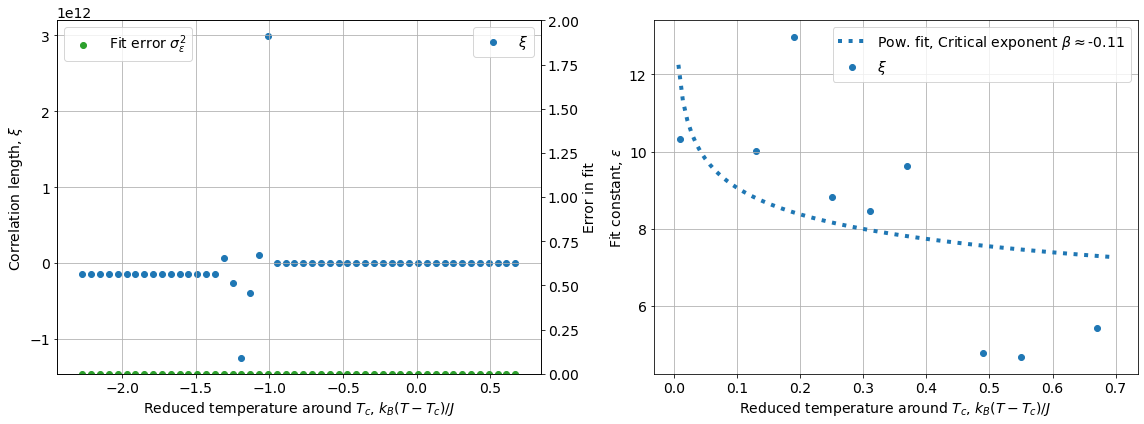

In [127]:
# Plot Ts and Eps
# Convert Ts to float
def power_law(x, A, eps):
    return A * x**eps


Tc = 2.27;
Ts = [float(T) for T in Ts]
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(np.array(Ts)-Tc, 1/np.array(eps), label=r'$\xi$')
# ax.set_ylim(0, 100)
ax_twin = ax[0].twinx()
ax_twin.set_ylim(0,2)
ax_twin.scatter(np.array(Ts)-Tc, unc_eps, color='C2', label=r'Fit error $\sigma^2_\epsilon$')
ax_twin.set_ylabel('Error in fit')
ax_twin.legend(loc='upper left')
ax[0].set_xlabel(r'Reduced temperature around $T_c$, $k_B (T-T_c)/J$')
ax[0].set_ylabel(r'Correlation length, $\xi$')
ax[0].legend(loc='upper right')
ax[0].grid()

x=np.linspace(0, 0.7,100)
# Pick out points to fit to
ps = 1/np.array(eps)[38:]
idx = np.where(ps < 25)
ps = ps[idx]
T = (np.array(Ts)-Tc)[38:]
T = T[idx]

ax[1].scatter(T, ps, label=r'$\xi$')
popt, pcov = curve_fit(power_law, T, ps)
print(popt)
ax[1].plot(x, power_law(x, popt[0], popt[1]), linewidth=4, linestyle=':', label=fr'Pow. fit, Critical exponent $\beta \approx ${popt[1]:.2f}')
# ax[1].set_ylim(0,20)
ax[1].legend(loc='upper right')
ax[1].grid()
ax[1].set_xlabel(r'Reduced temperature around $T_c$, $k_B (T-T_c)/J$')
ax[1].set_ylabel(r'Fit constant, $\epsilon$')
plt.tight_layout()
plt.savefig(f'problem3_output/N={N}/xi.png')

print(len(ps))
print(len(T))

# Plot lattices

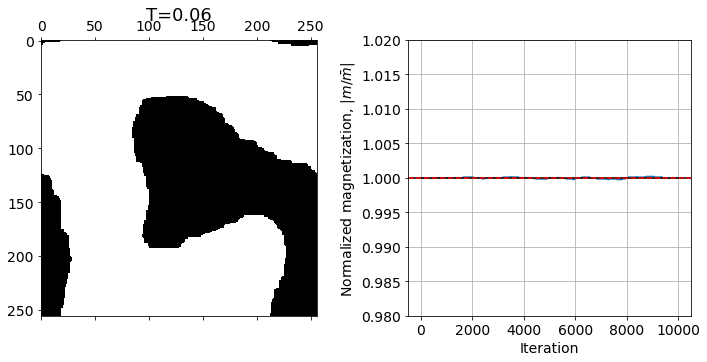

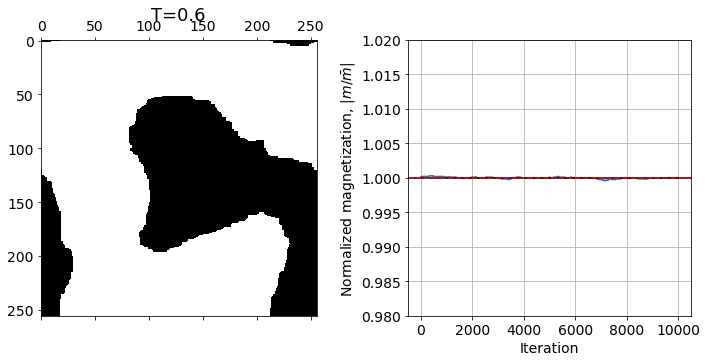

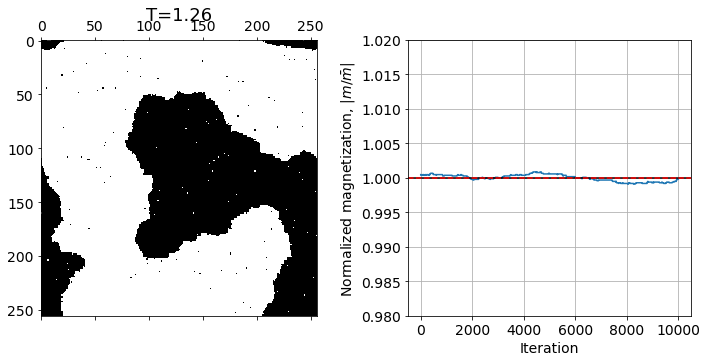

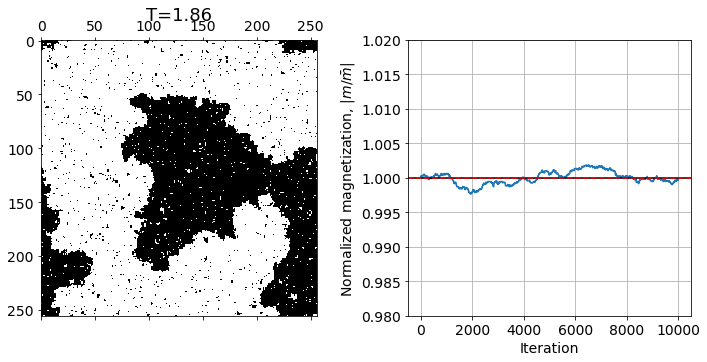

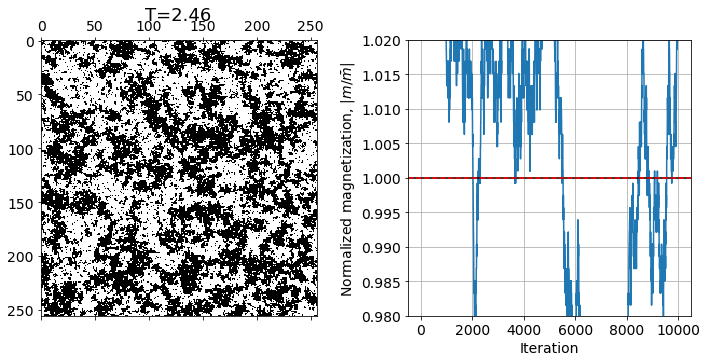

In [54]:
# Plot final lattice
traces = 'problem3_output/N=256/traces/'
path = 'problem3_output/N=256/lattices/'



for idx, filename in enumerate(os.listdir(path)):
    if filename.endswith(".dat") and idx%10==0: 
        data_lat = np.loadtxt(path + filename)
        Temperature = filename.split('_')[0]
        trace_name = Temperature + '_magnetization_trace.dat'
        data_trac = np.loadtxt(traces + trace_name)
        fig, ax = plt.subplots(1,2,figsize=(10,5))
        ax[0].matshow(data_lat, cmap=plt.cm.gray_r)
        ax[0].set_title(Temperature)
        
        ax[1].plot(data_trac[np.where(data_trac != 0)]/np.mean(data_trac))
        ax[1].axhline(1, color='k')
        ax[1].axhline(1+1e-5, color='r', linestyle='--')
        ax[1].set_ylim(0.98, 1.02)
        ax[1].set_xlabel(r'Iteration')
        ax[1].set_ylabel(r'Normalized magnetization, $|m/\bar{m}|$')
        ax[1].grid()
        plt.tight_layout()